# Creating maps

In this notebook, some examples of creating maps in Python using the [Cartopy library](http://scitools.org.uk/cartopy/) are shown. We will zoom in from the global scale to the local scale.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## Projections

A complete list of available projections can be found here. The examples below show how to plot a coarse-resolution coastlines of the entire globe. A list of projections available in Cartopy can be found here: http://scitools.org.uk/cartopy/docs/v0.15/crs/projections.html#

#### Equirectangular

This projection just maps longitude to the x-axis and and latitude to the y-axis. It distorts and stretches areas away from the equator.

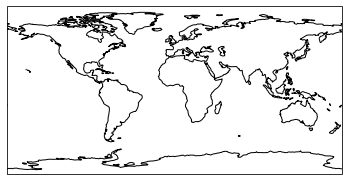

In [2]:
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

#### Mercator

The Mercator projection expands latitude and longitude at the same *ratio* away from the equator. As a result, areas are stretched equally horizontally and vertically such at angles are preserved (i.e. it is conformal). Notice that Greenland and Africa are the same size in this map, which is not true if you look at a globe.

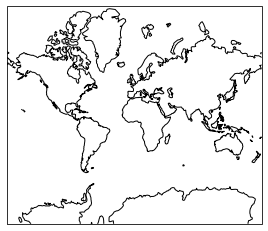

In [3]:
plt.figure()
ax = plt.axes(projection=ccrs.Mercator())
ax.coastlines()

#### Lambert conformal

This is another projection that is conformal and preserves angles. It is a *conic* projection, so it is better for displaying large areas at mid-latitudes.

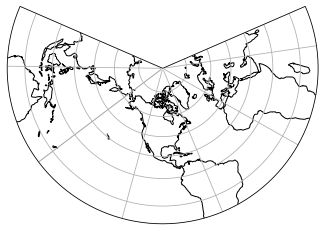

In [4]:
plt.figure()
ax = plt.axes(projection=ccrs.LambertConformal())
gl = ax.gridlines()
ax.coastlines()

## Adding gridlines

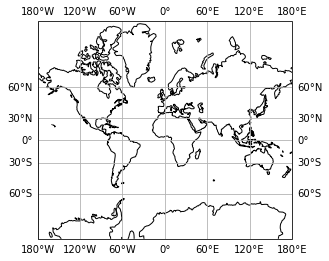

In [5]:
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

plt.figure()
ax = plt.axes(projection=ccrs.Mercator())
gl = ax.gridlines(draw_labels=True)
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
ax.coastlines()

It can be hard to remember all of these commands. It is easier to make a function. This function is based on a blog post by Filipe Fernandes at https://ocefpaf.github.io/python4oceanographers/blog/2015/06/22/osm/. For a given projection, it returns an axis object that can be used by Cartopy.

/Users/tomconnolly/programs/miniconda3/envs/ms263-21/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/Users/tomconnolly/programs/miniconda3/envs/ms263-21/lib/python3.8/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


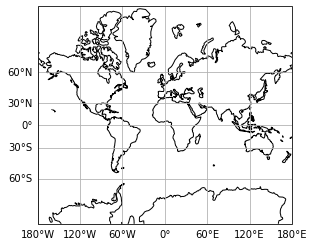

In [6]:
def make_map(projection=ccrs.PlateCarree()):
    '''
    Return axis object for cartopy map with labeled gridlines.
    
    Input: Cartopy projection, default = cartopy.crs.PlateCarree()
    Output: Cartopy axis object
    
    Based on blog post by Filipe Fernandes:
    https://ocefpaf.github.io/python4oceanographers/blog/2015/06/22/osm/
    License: Creative Commons Attribution-ShareAlike 4.0
    https://creativecommons.org/licenses/by-sa/4.0/
    
    Example code:
    
    import cartopy.crs as ccrs
    plt.figure()
    ax = make_map(projection=ccrs.Mercator())
    ax.coastlines()
    '''
    ax = plt.axes(projection=projection)
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return ax

plt.figure()
ax = make_map(ccrs.Mercator())
ax.coastlines()

## Higher resolution coastline for smaller areas

Here we make a map of Monterey Bay. Using the default coastline, it doesn't work out so well.

In [7]:
# map extent for Monterey Bay
extent = [-122.3, -121.6, 36.5, 37.1]

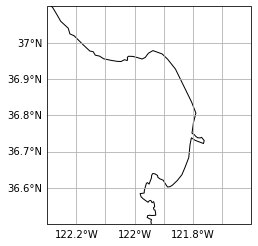

In [8]:
plt.figure()
ax = make_map(ccrs.Mercator())
ax.set_extent(extent)
ax.coastlines()

The following code produces a higher resolution coastline. The coastline data sets in Cartopy come from [Natural Earth](http://www.naturalearthdata.com/). The '10m' option refers to resolution that is appropriate for a 1:10 million scale map, not 10 meter resolution.

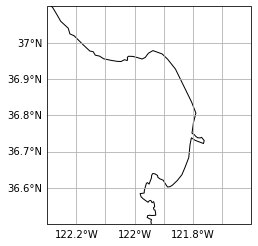

In [9]:
plt.figure()
ax = make_map(ccrs.Mercator())
ax.set_extent(extent)
ax.coastlines('10m')

We can also easily grab image tiles from the internet to show the same area. This example shows tiles from the familiar Google Maps. You can also show tiles from [Stamen Terrain](http://maps.stamen.com/terrain).

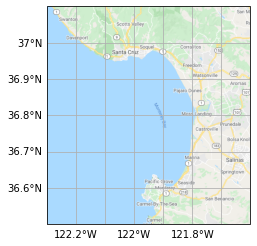

In [10]:
import cartopy.io.img_tiles as cimgt
request = cimgt.GoogleTiles()

plt.figure()
ax = make_map(projection=request.crs)
ax.set_extent(extent)
ax.add_image(request,10)

<ipython-input-11-0957d03eb5a0>:2: DeprecationWarning: The StamenTerrain class was deprecated in v0.17. Please use Stamen('terrain-background') instead.
  request = cimgt.StamenTerrain()


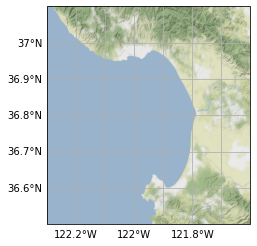

In [11]:
import cartopy.io.img_tiles as cimgt
request = cimgt.StamenTerrain()

plt.figure()
ax = make_map(projection=request.crs)
ax.set_extent(extent)
ax.add_image(request,10)

## Using shapefiles

GIS data often uses the binary shapefile format. Cartopy includes tools that greatly simplify the process of reading these files in Python. To demonstrate, we will map out wetlands and roads near Elkhorn Slough from data contained in GIS shapefiles.

The following code uses data that can be downloaded from the Elkhorn Slough Foundation website:
http://www.elkhornslough.org/gis/index.htm

As noted on the site, the shapefiles use a Universal Transverse Mercator Zone 10 projection to convert between distance in meters, and latitude and longitude. They use the WGS84 datum to specify the shape of the ellipsoidal Earth, which is the default in Cartopy. It is important that we specify the same projection when reading the data. Here, we create a custom projection, `p`.

In [13]:
from cartopy.io import shapereader

wetshp = shapereader.Reader('data/Elkhorn_Slough_GIS/WETLAND/wetland.shp')
p = ccrs.UTM(zone=10)

The data can be displayed by following two steps

1) Creating a Cartopy axis object, which can be any projection you want (Mercator in this case). This is similar to the plots created earlier.

2) Looping through the geometries contained in the shapefile, and adding them to the map. Our custom projection must be specified here when reading the shapefile. This ensures that there is a correct conversion from distance in meters (the information contained in the shapefile) to longitude and latitude (which is what we want to plot).

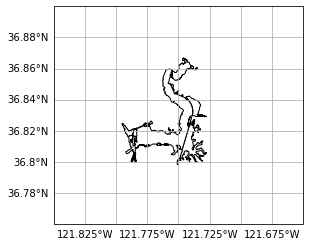

In [22]:
plt.figure()

extent = ([-121.85,-121.65,36.76,36.9])
ax = make_map(projection=ccrs.Mercator())
ax.set_extent(extent)

for geometry in wetshp.geometries():
    try:
        ax.add_geometries(geometry, p, facecolor='white',
                          edgecolor='black')
    except:
        pass